# Model selection
Perhaps we do not know the number of segments in a rating or that a power law is better than another type of model.
In these situations, we want to compare the performance of one model against another, 
then select whichever models gives the best fit for the data.
More specifically, we want to know the generalization performance of each model,
which refers to their performance on new (out-of-sample) data.

One way to estimate generalization performance is cross validation, but it can be costly.
In cross validation, a portion of the data is held out. 
If you don't have a lot of data to begin with,
holding out a portion can substantially degrade model fit.

An alternative approach is to use information criteria,
which are measures that use in-sample data to estimate out-of-sample performance.

In this tutorial, we demonstrate how to select the number of segments in the Green River rating.
We fit the rating with 1, 2, 3, and 4 segments, then use information criteria to select the number of segments that gives the best fit.

In [3]:
## Load the data
from ratingcurve import data
%load_ext autoreload
%autoreload 2
%xmode minimal
#suppress warnings and errors

import pymc as pm
import arviz as az
from ratingcurve.ratings import PowerLawRating

from ratingcurve import data

df = data.load('green channel')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Minimal


## Fit the data
Fit the data to ratings with 1 to 4 segments.

In [13]:
%%capture
# Output supressed, this will print "Finished" after running each of the four models

segments = [1, 2, 3, 4]
traces = []
for segment in segments:
    powerrating = PowerLawRating(segments=segment,
                                 prior={'distribution':'uniform'})

    trace = powerrating.fit(q=df['q'],
                            h=df['stage'], 
                            q_sigma=df['q_sigma'],
                            n=100_000)
    
    traces.append(pm.compute_log_likelihood(trace, model=powerrating.model)) # Add arg to compute log likelihood

Convergence achieved at 44800
Interrupted at 44,799 [44%]: Average Loss = 103.01
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]
Convergence achieved at 74500
Interrupted at 74,499 [74%]: Average Loss = 59.073
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]
Finished [100%]: Average Loss = -48.248
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]
Finished [100%]: Average Loss = -44.213
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


Now use `arviz.compare` to format the output.

In [14]:
# this model will generate warnings about the LOO
import warnings; warnings.filterwarnings('ignore')

compare_dict = {f'{i} segment': traces[i-1] for i in segments}
az.compare(compare_dict, ic='LOO')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
2 segment,0,73.495791,5.909181,0.000000,1.000000e+00,3.276638,0.000000,True,log
3 segment,1,67.650866,11.842002,5.844925,9.290346e-13,6.701047,5.601992,True,log
4 segment,2,57.947926,21.062821,15.547865,7.531753e-13,13.942271,13.358029,True,log
1 segment,3,53.784628,3.798565,19.711163,0.000000e+00,3.277936,4.363762,False,log


As expected, the 2-segment model ranked highest.

## Residual analysis
In practice, it can be helpful to plot to rating error
(the deviations between the rating fit and the discharge observations).
Here is a demonstration of how.

In [15]:
segments = 2

powerrating = PowerLawRating(segments=2,
                             prior={'distribution':'uniform'})

trace = powerrating.fit(q=df['q'],
                        h=df['stage'], 
                        q_sigma=df['q_sigma'])

Finished [100%]: Average Loss = -51.655
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


RuntimeError: The model hasn't been fit yet, call .fit().

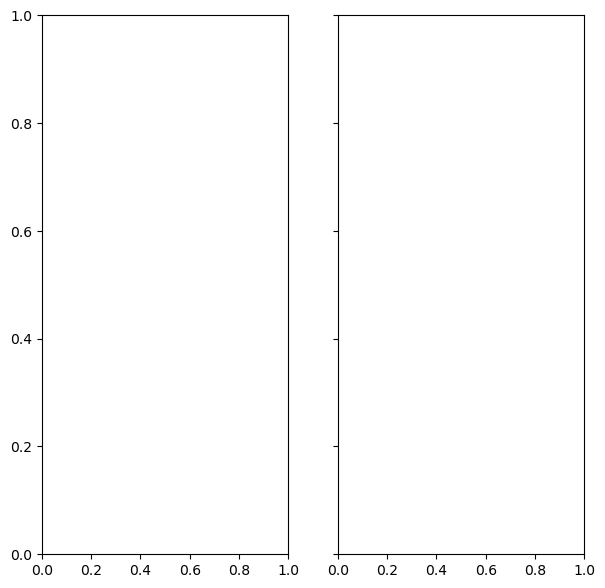

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(7,7), sharey=True)

powerrating.plot(ax[0])
powerrating.plot_residuals(ax[1])


plt.subplots_adjust(wspace=0.1)
ax[1].set_ylabel('')

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray